<a href="https://colab.research.google.com/github/rih28/dataAnalytics/blob/master/Part_4_4_1R.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
ls <- read.csv("/content/sample_data/california_housing_train.csv")

In [3]:
head(ls)

longitude latitude housing_median_age total_rooms total_bedrooms population
1 -114.31   34.19    15                 5612        1283           1015      
2 -114.47   34.40    19                 7650        1901           1129      
3 -114.56   33.69    17                  720         174            333      
4 -114.57   33.64    14                 1501         337            515      
5 -114.57   33.57    20                 1454         326            624      
6 -114.58   33.63    29                 1387         236            671      
  households median_income median_house_value
1 472        1.4936        66900             
2 463        1.8200        80100             
3 117        1.6509        85700             
4 226        3.1917        73400             
5 262        1.9250        65500             
6 239        3.3438        74000

The above should be familiar, we have done the same thing a few times now. What should we do first:

**1. Look at the big picture**

The task you have been asked to do is to build a model of housing prices in California using the California census data. This data has metrics such as the population, median income, median housing price, and so on for each district in California. Districts typically have a population of 600 to 3000 people.

Your model should learn from this data and be able to predict the median housing price in any district, given all other metrics.

Since you are a well-organised data scientist, the first thing you do is to pull out your ML project checklist. See Appendix A at the end of this document.

We will use some of the checklist items in Appendix A as some are not relevant (as outlined at the start of this section).

*Frame the problem*

The first thing you do is ask your boss “what is the business objective?” How does the company expect to use and benefit from your model? This is important because it will determine how you frame the problem, what algorithms you will select, what performance measure you will use to evaluate your model, and how much effort you should spend tweaking it.

In this instance, your boss answers that your model’s output (i.e. a prediction of a district’s median housing price) will be fed to another ML system along with many other signals. This downstream system will determine whether it is worth investing in a particular area or not. Getting this right is critical, as it directly affects revenue.

*As a note, a sequence of data processing components is called a data pipeline. Pipelines are common in ML systems, since there is a lot of data to manipulate and many data transformations to apply.

Components usually run asynchronously. Each component pulls in a large amount of data, processes it, and gives out the result in to another data store, then some time later the next component in the pipeline pulls this data and gives out its own output, and so on. Each component is fairly self- contained (i.e. the interface between components is simply the data store). This makes the system quite simple to grasp with the help of a data flow graph, and different teams can focus on different components. Moreover, if a component breaks down, the downstream components can often continue to run normally by just using the last output from the broken component. This makes the architecture quite robust. On the other hand, a broken component can go unnoticed for some time if proper monitoring is not implemented. The data gets stale and the overall system’s performance drops.

The next question to ask is what the existing solution looks like (if any). It will often give you a reference performance, as well as insights on how to solve the problem. Your boss answers that the district housing prices are currently estimated manually by experts i.e. a team gathers up-to-date information about a district, and when they cannot get the median housing price, they estimate it using complex rules.

This is costly and time consuming and the estimates are not great (in cases where they manage to find out the actual median housing price, their estimates are off by more than 10%). This is why the company thinks that it would be useful to train a model to predict a district’s median housing price given other data about that district. The census data looks like a great dataset to exploit for this purpose, since it includes the median housing prices of thousands of districts, as well as other data.

With all this information you are now ready to start designing your system. First you need to frame the problem, so for example, is it supervised, unsupervised, or Reinforcement Learning? Is it a classification task, a regression task, or something else? Should you use batch learning or online learning techniques?

Here, it is clearly a supervised learning task since you are given labelled training examples (each instance comes with the expected output, i.e. the district’s median housing price). It is also a typical regression task, since you are asked to predict a value. More specifically, this is a multivariate regression problem since the system will use multiple features to make a prediction (i.e. it will use the district’s population, the median income, etc.). The example from earlier in the course with life satisfaction was a univariate regression problem as you used only one feature, the GDP per capita. Finally, there is no continuous flow of data coming in the system, there is no need to adjust to changing data rapidly, and the data is small enough to fit in memory, so plain batch learning should be fine.

If the data was massive, you could either split your batch learning across multiple servers, or you could use an online learning technique instead.




*Select a Performance Measure*

Your next step is to select a performance measure. A typical performance measure for regression problems is the Root Mean Square Error (RMSE). It gives an idea of how much error the system makes in its predictions, with higher weight for large errors:

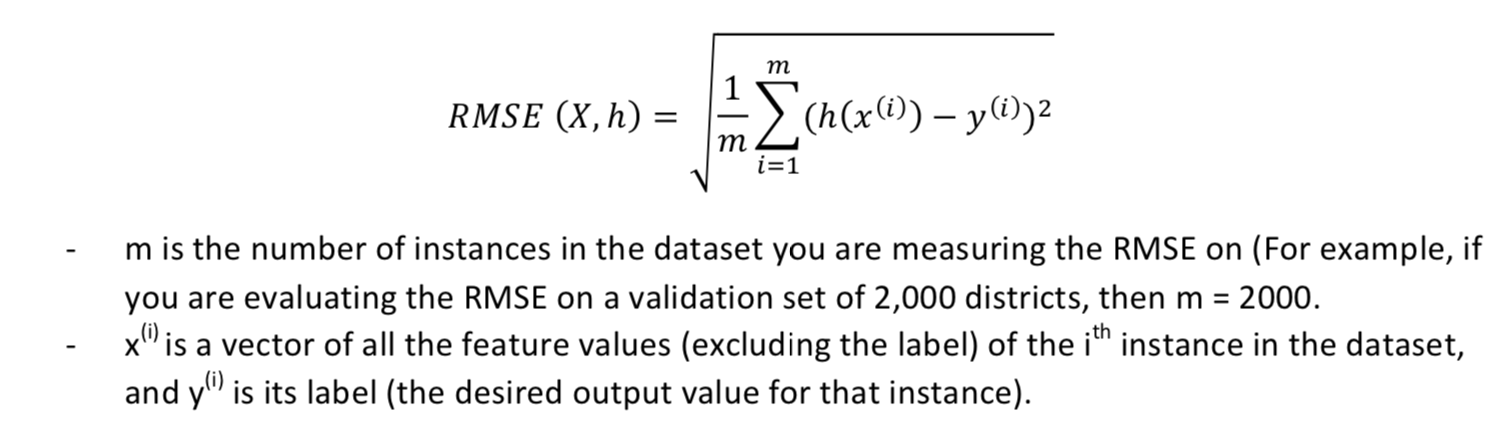

For example, if the first district in the dataset is located at longitude -118.29, latitude 33.91, and it had 1416 inhabitants with a median income of $38,372, and the median house value is $156,400 (ignoring the others for now), then:

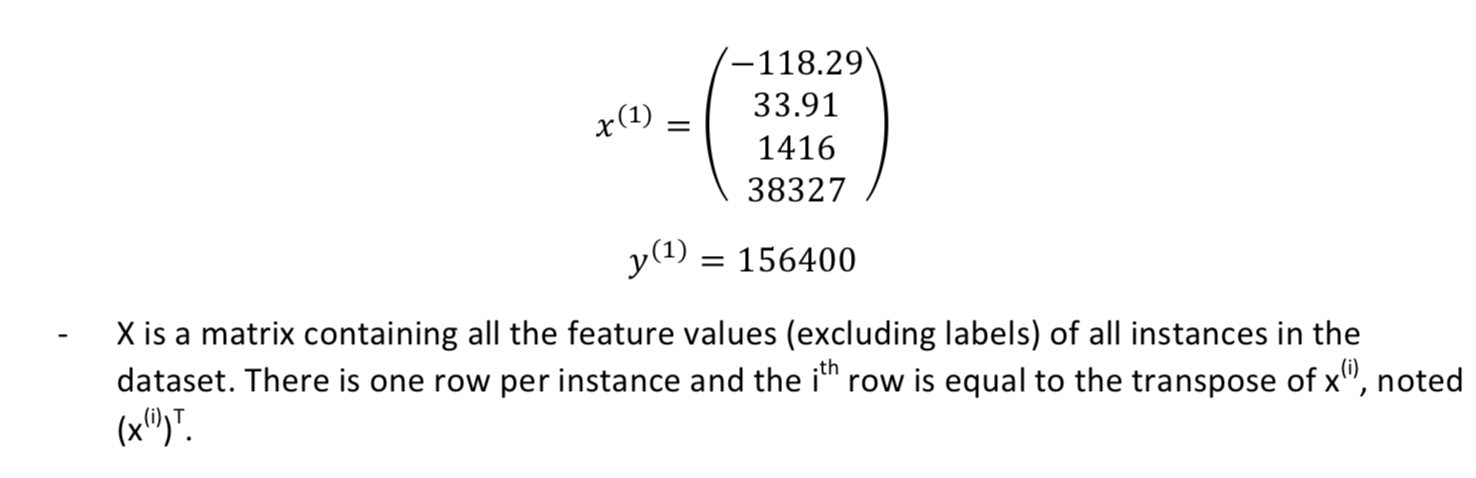

For example, if the first district is as just described, then the matrix X looks like this:

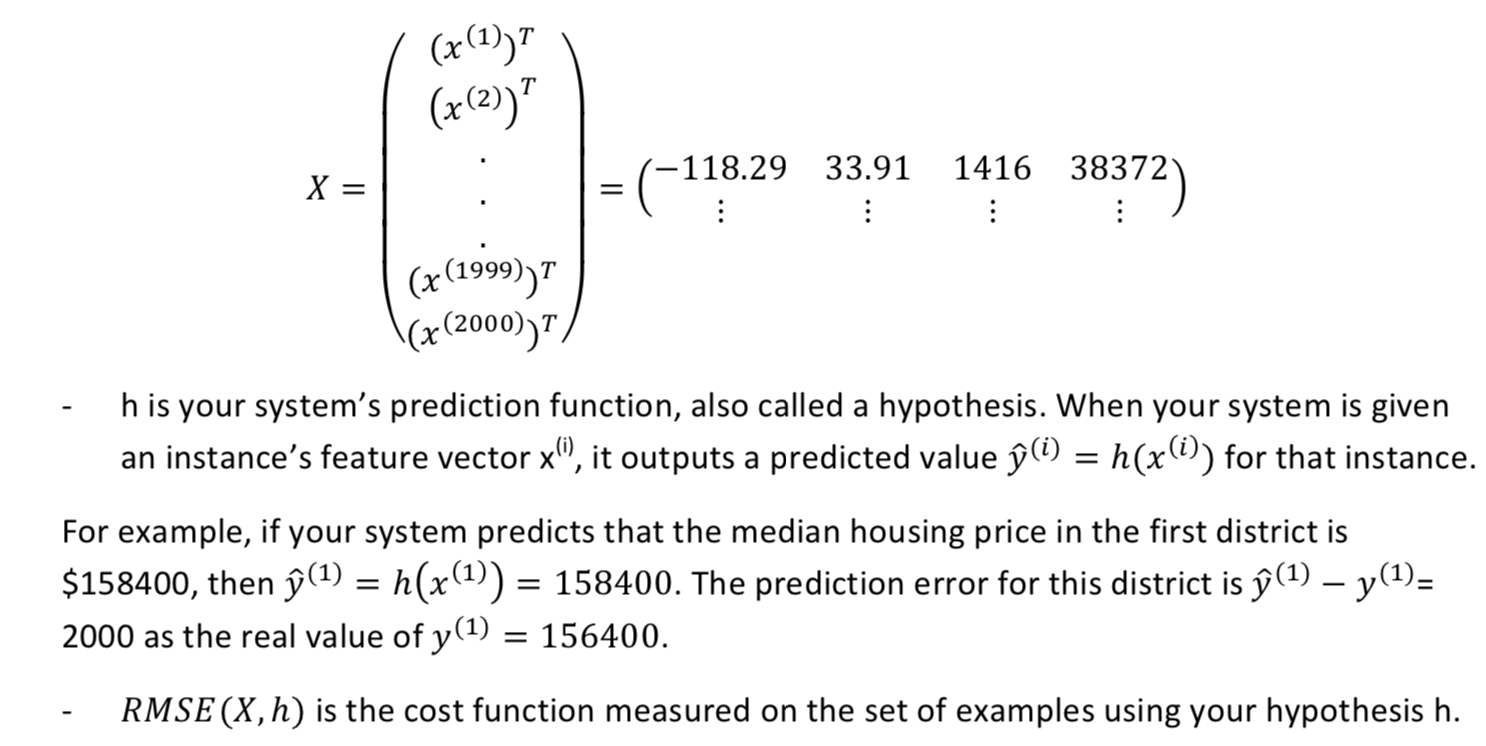

Even though RMSE is generally the preferred performance measure for regression tasks, in some contexts you may prefer to use another function. For example, suppose there are many outlier districts. In that case, you may consider using the Mean Absolute Error.

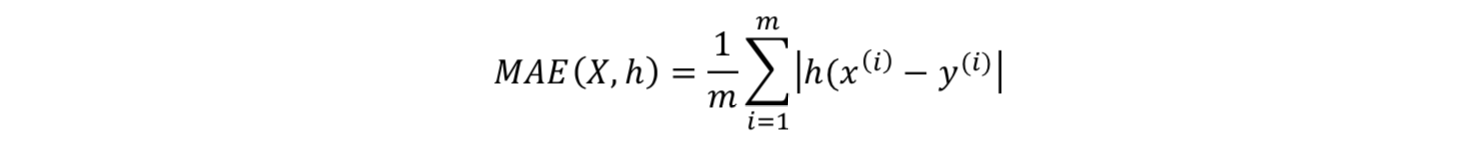

Both the RMSE and the MAE are ways to measure the distance between: the vector of predictions and the vector of target values.

*Check the assumptions*

It is good practice to list and verify the assumptions that were made so far (by you and others); this can catch serious issues early on. For example, the district prices that your system outputs are going to be fed into a downstream ML system, and we assume that these prices are going to be used as such. But what if the downstream system actually converts the prices into categories (e.g., “cheap”, “medium”, or “expensive”) and uses those categories instead of the prices themselves? In this case, getting the price perfectly right is not important at all; your system just needs to get the category right. If that is so, then the problem should have been framed as a classification task, not a regression task. You don’t want to find this out after working on a regression system for months.

Fortunately, after talking with the team in charge of the downstream system, you are confident that they need the actual prices, not just categories. Now it’s time to start coding.



**2. Get the data**

At this point, we are going to extract the coding of the ML with some Data Analytics in the first instance. Usually, you would be doing this together. The reason for this decision, is that you have been learning about Data Science using R and it makes sense to do some investigative work with the tool you have learned to use.

*Have a quick look at the data structure*

Let’s get a quick description of the data, in particular the total number of rows, and each attributes type and the number of non-null values.

In [4]:
# basic descriptive information
str(ls);

'data.frame':	17000 obs. of  9 variables:
 $ longitude         : num  -114 -114 -115 -115 -115 ...
 $ latitude          : num  34.2 34.4 33.7 33.6 33.6 ...
 $ housing_median_age: num  15 19 17 14 20 29 25 41 34 46 ...
 $ total_rooms       : num  5612 7650 720 1501 1454 ...
 $ total_bedrooms    : num  1283 1901 174 337 326 ...
 $ population        : num  1015 1129 333 515 624 ...
 $ households        : num  472 463 117 226 262 ...
 $ median_income     : num  1.49 1.82 1.65 3.19 1.93 ...
 $ median_house_value: num  66900 80100 85700 73400 65500 74000 82400 48500 58400 48100 ...


In [5]:
# find non-null values i.e. the length of the column where the values are non-null
apply(ls, 2, function(x) length(which(!is.na(x))))

longitude           latitude housing_median_age        total_rooms 
             17000              17000              17000              17000 
    total_bedrooms         population         households      median_income 
             17000              17000              17000              17000 
median_house_value 
             17000

Looks like there are no null values because all of the lengths for each column header is the same. We have 17000 instances in the dataset which is fairly small in terms of ML, but it is a good point to start learning. Now let's look at a summary of all the fields using the summary and the sapply commands.



In [6]:
# general descriptive stats
summary(ls)

   longitude         latitude     housing_median_age  total_rooms   
 Min.   :-124.3   Min.   :32.54   Min.   : 1.00      Min.   :    2  
 1st Qu.:-121.8   1st Qu.:33.93   1st Qu.:18.00      1st Qu.: 1462  
 Median :-118.5   Median :34.25   Median :29.00      Median : 2127  
 Mean   :-119.6   Mean   :35.63   Mean   :28.59      Mean   : 2644  
 3rd Qu.:-118.0   3rd Qu.:37.72   3rd Qu.:37.00      3rd Qu.: 3151  
 Max.   :-114.3   Max.   :41.95   Max.   :52.00      Max.   :37937  
 total_bedrooms     population      households     median_income    
 Min.   :   1.0   Min.   :    3   Min.   :   1.0   Min.   : 0.4999  
 1st Qu.: 297.0   1st Qu.:  790   1st Qu.: 282.0   1st Qu.: 2.5664  
 Median : 434.0   Median : 1167   Median : 409.0   Median : 3.5446  
 Mean   : 539.4   Mean   : 1430   Mean   : 501.2   Mean   : 3.8836  
 3rd Qu.: 648.2   3rd Qu.: 1721   3rd Qu.: 605.2   3rd Qu.: 4.7670  
 Max.   :6445.0   Max.   :35682   Max.   :6082.0   Max.   :15.0001  
 median_house_value
 Min.   : 1499

In [7]:
# for the standard deviation
sapply(ls, sd, na.rm=TRUE)

longitude           latitude housing_median_age        total_rooms 
      2.005166e+00       2.137340e+00       1.258694e+01       2.179947e+03 
    total_bedrooms         population         households      median_income 
      4.214995e+02       1.147853e+03       3.845208e+02       1.908157e+00 
median_house_value 
      1.159838e+05

For the general descriptive stats, the mean, min and max rows are self-explanatory. The std or standard deviation measures how dispersed the values are. The 1st and 3rd Quartiles are percentiles and they indicate the value below which a given percentage of observations in a group of observations falls. The median is exactly halfway and is a type of average. An example would be, 25% of the districts have a housing_median_age lower than 18, while 50% are lower than 29 and 75% are lower than 37.

A really good way to get a quick understanding of the data you are dealing with is to plot a histogram. I will show you how to plot all of them one attribute at a time below and they will be commented out (i.e. with a #) except median_house_value where you can see that slightly over 800 districts have a median_house_value equal to about $100000.

In [8]:
# set colour for plots
colours = c("blue")

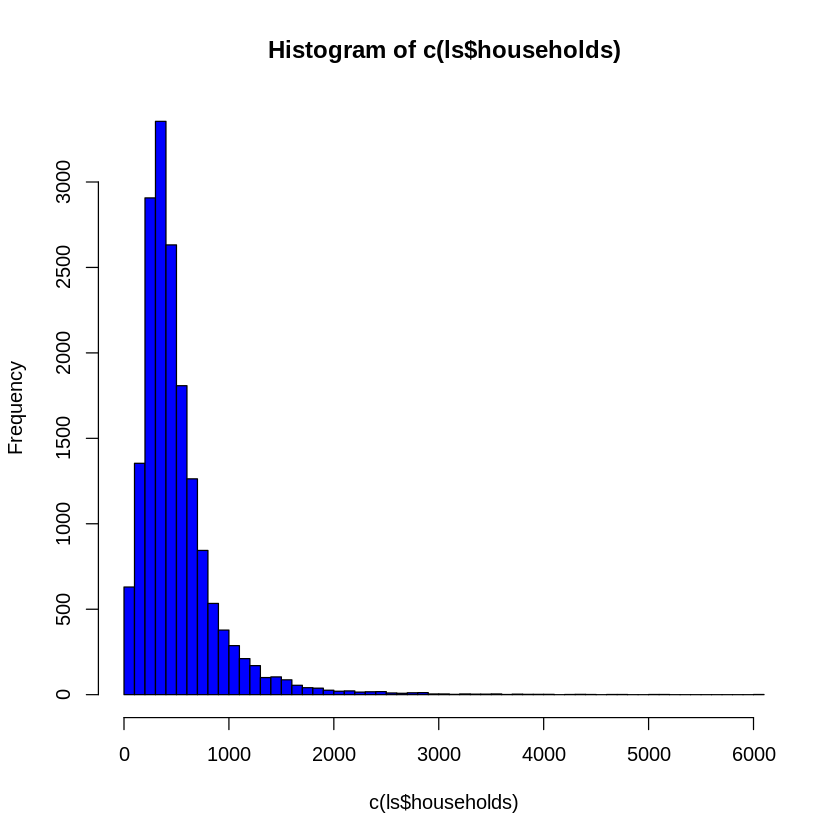

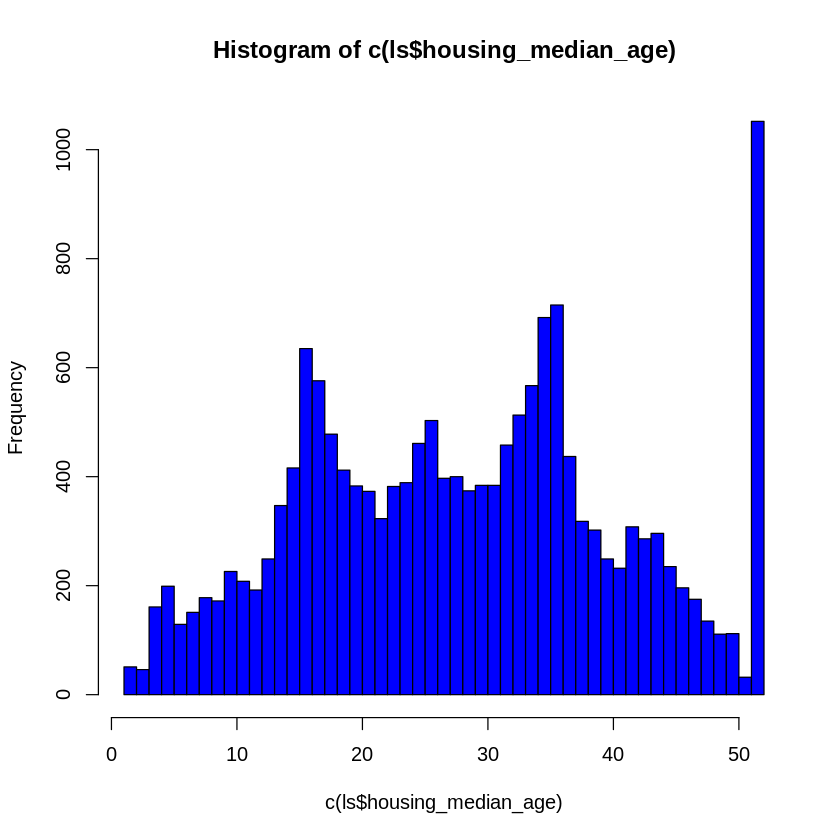

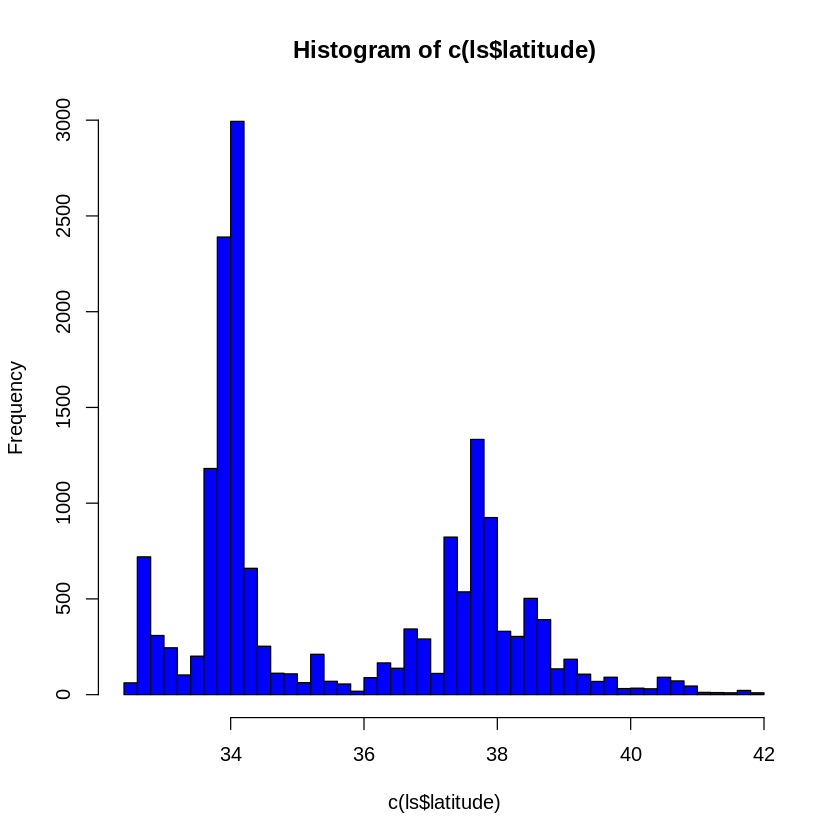

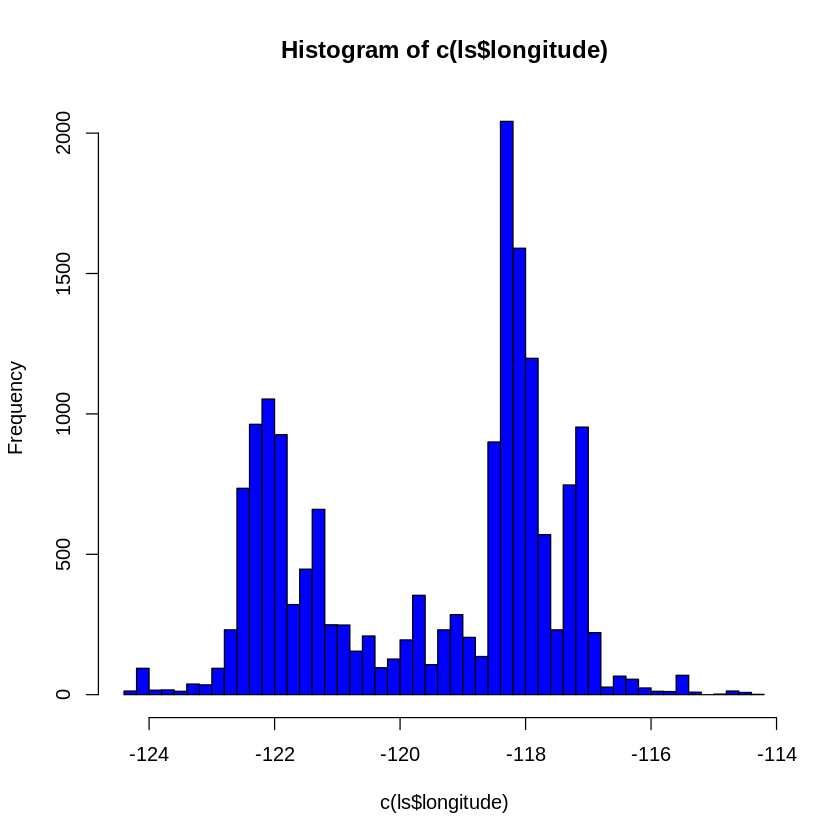

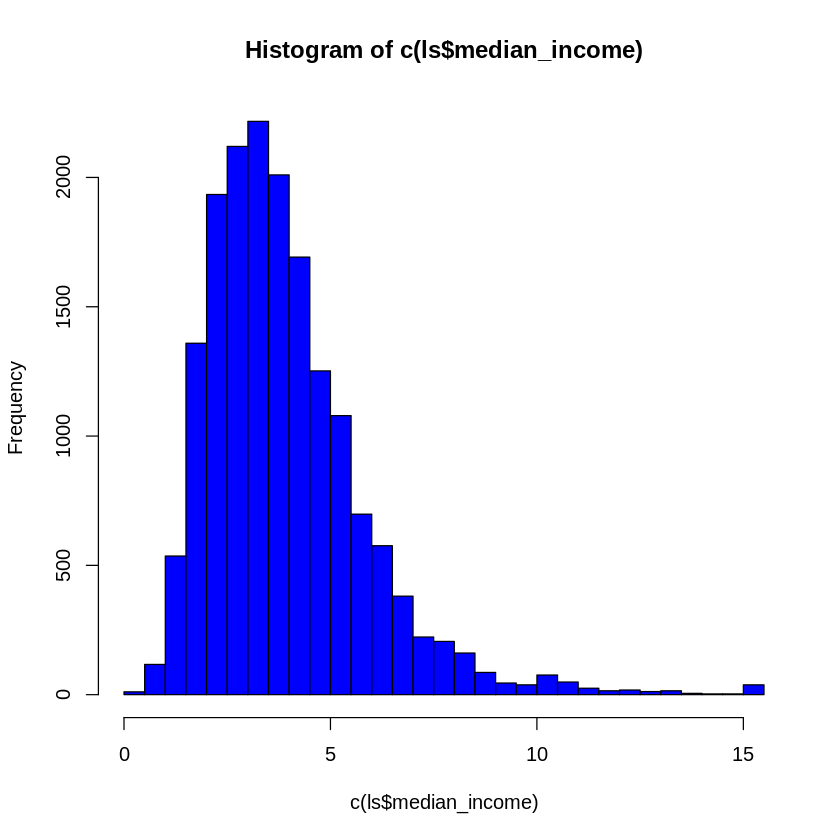

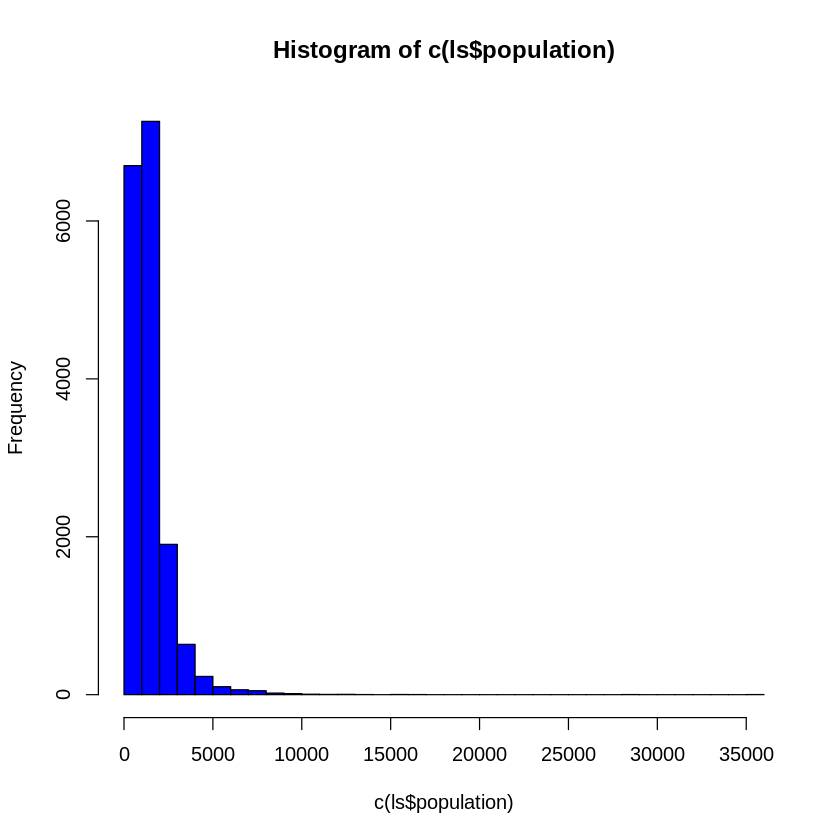

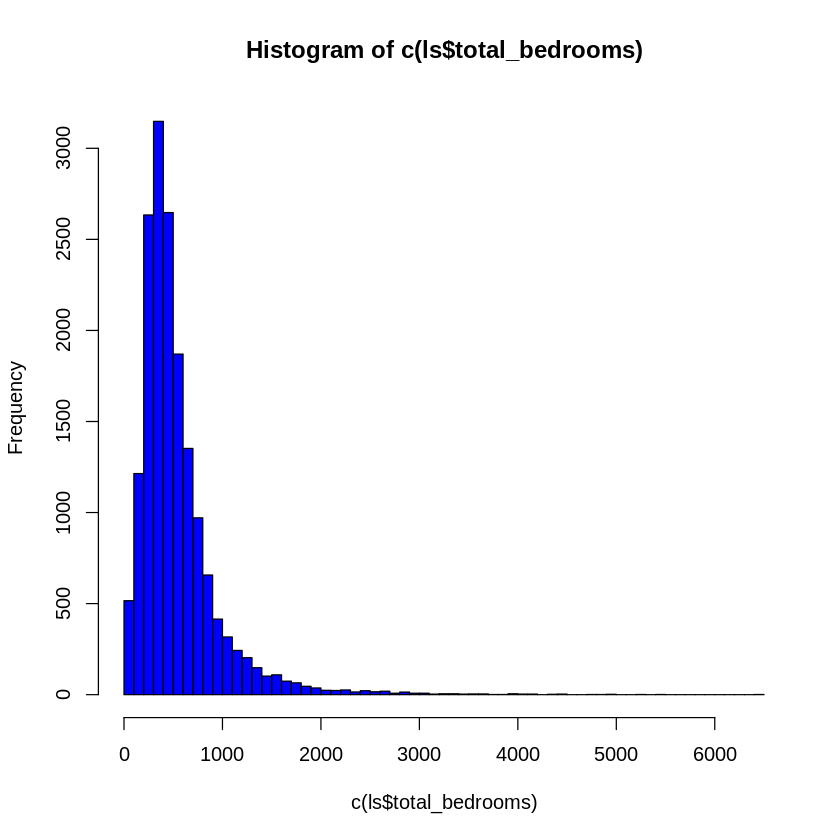

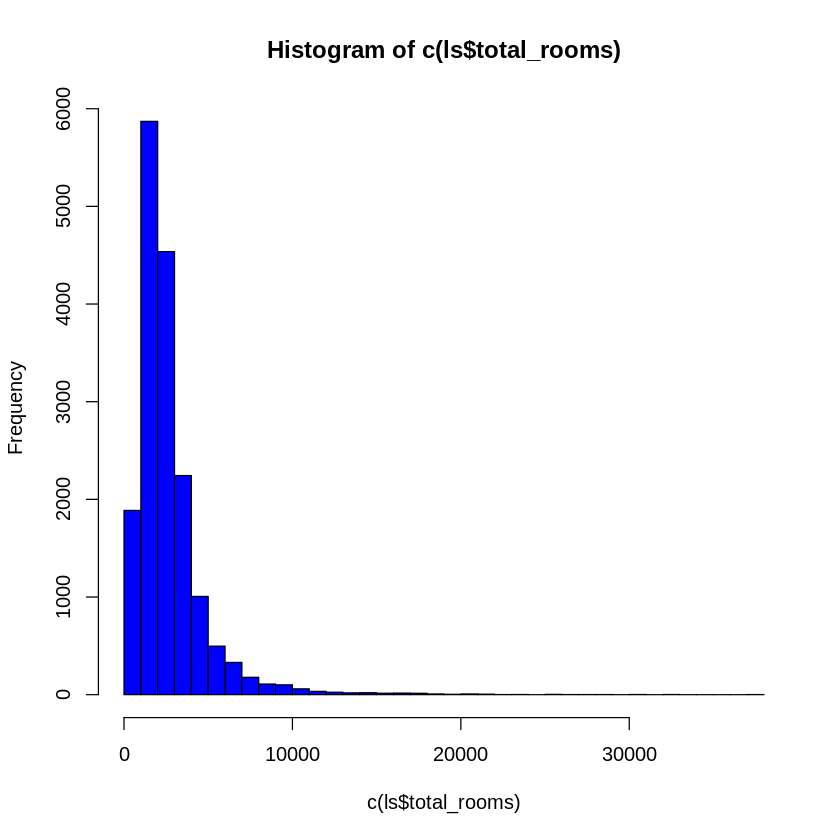

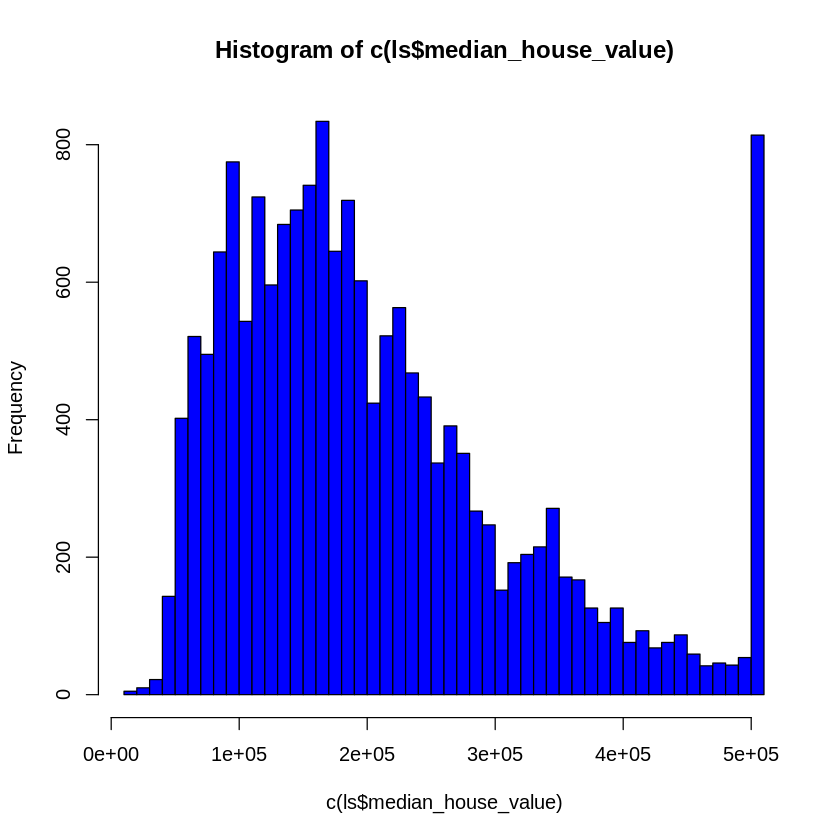

In [9]:
# histograms for all attributes
hist(c(ls$households), breaks=50, col=colours) # breaks are the same as bins
hist(c(ls$housing_median_age), breaks=50, col=colours) # breaks are the same as bins
hist(c(ls$latitude), breaks=50, col=colours) # breaks are the same as bins
hist(c(ls$longitude), breaks=50, col=colours) # breaks are the same as bins
hist(c(ls$median_income), breaks=50, col=colours) # breaks are the same as bins
hist(c(ls$population), breaks=50, col=colours) # breaks are the same as bins
hist(c(ls$total_bedrooms), breaks=50, col=colours) # breaks are the same as bins
hist(c(ls$total_rooms), breaks=50, col=colours) # breaks are the same as bins
hist(c(ls$median_house_value), breaks=50, col=colours) # breaks are the same as bins

So, what do the histograms tell us at a glance?
1. The median income attribute is not expressed in Dollars and has been capped at 15 for higher median incomes, and 0.5 for lower median incomes. This issue is command and is known as preprocessed attributes. It’s not really a problem, but it must be understood.
2. Housing median age and median house value have also been capped. The latter may be a problem as it is your target attribute i.e. label. So, your ML may learn never to go beyond that limit. You will need to ask the team if this is an issue i.e. if you need precise figures above $500000. If so, you can either; Collect proper labels for the district where the labels are capped or remove these districts from the training set and also from the test set.
3. The attributes all have very different scales!?! We will find out later about scaling.
4. Histograms are tail heavy i.e. they extend too far to the right from the median than the left.
We should try transforming these attributes later to a more normal distribution.

**Create a test set**

This would normally be what we are required to do, however, they have already been separated and are in Colab. See the folder on the left of this window and look in sample data. We are currently using the training set. 

So, next step, create a train and test dataset. 

In [10]:
train <- read.csv("/content/sample_data/california_housing_train.csv")
test <- read.csv("/content/sample_data/california_housing_test.csv")

# check number of rows
nrow(train)
nrow(test)

[1] 17000

[1] 3000

This is an 85%/15% split. Usually I would go for 80% to 20%. 

Now, let's scope out the data in both and do some comparison.

In [11]:
head(train)

longitude latitude housing_median_age total_rooms total_bedrooms population
1 -114.31   34.19    15                 5612        1283           1015      
2 -114.47   34.40    19                 7650        1901           1129      
3 -114.56   33.69    17                  720         174            333      
4 -114.57   33.64    14                 1501         337            515      
5 -114.57   33.57    20                 1454         326            624      
6 -114.58   33.63    29                 1387         236            671      
  households median_income median_house_value
1 472        1.4936        66900             
2 463        1.8200        80100             
3 117        1.6509        85700             
4 226        3.1917        73400             
5 262        1.9250        65500             
6 239        3.3438        74000

In [12]:
head(test)

longitude latitude housing_median_age total_rooms total_bedrooms population
1 -122.05   37.37    27                 3885        661            1537      
2 -118.30   34.26    43                 1510        310             809      
3 -117.81   33.78    27                 3589        507            1484      
4 -118.36   33.82    28                   67         15              49      
5 -119.67   36.33    19                 1241        244             850      
6 -119.56   36.51    37                 1018        213             663      
  households median_income median_house_value
1 606        6.6085        344700            
2 277        3.5990        176500            
3 495        5.7934        270500            
4  11        6.1359        330000            
5 237        2.9375         81700            
6 204        1.6635         67000

This looks good, the number of rows make sense and the the data looks nice and random. However, are random samples the right thing to do? In a very large data set, yes, however, in our case, we run the risk of significant sampling bias. We need to apply stratified sampling i.e. the population is divided up into homogenous groups called strata, and the correct number of instances from each group are selected to best represent the overall data. In this course, you wont have to worry too much about this. Just to let you know

In this instance, the data is pre-prepared so we can safely move on.

**3. Discover and visualise the data to gain insights**

Now we will go more in-depth and we will only be using the training data (so hypothetically, you
should keep the test data aside.

*Let’s visualise the geographical data*

Since there is latitude and longitude, it is a good idea to plot the data as a scatter plot. Note, make a copy of the training data:

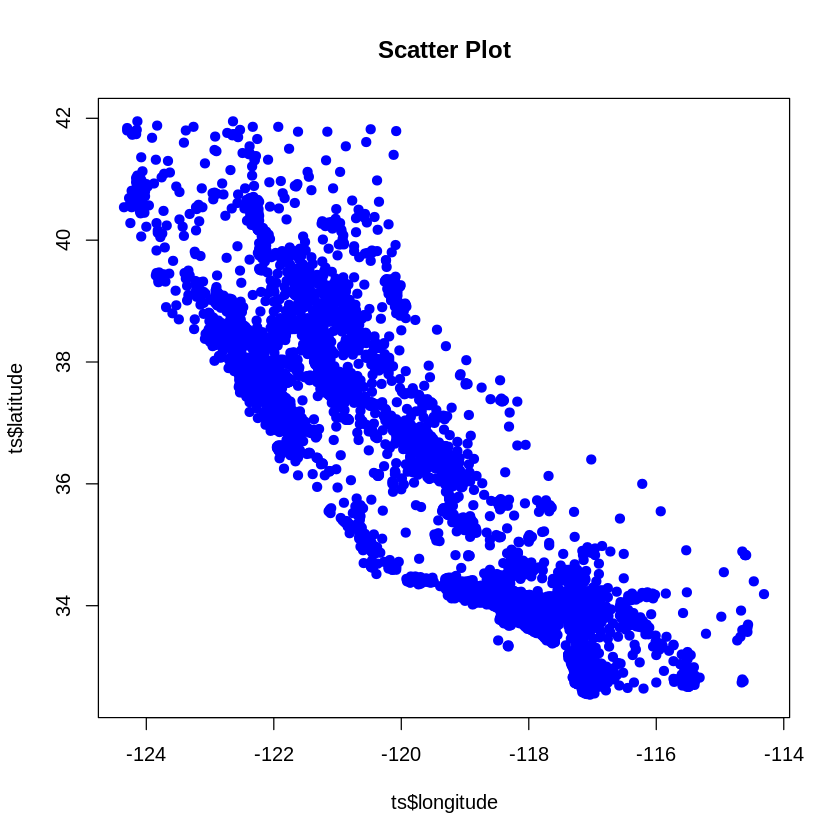

In [13]:
# make copy of the training data
ts <- train

# draw scatter plot of lat and lon
plot(ts$longitude, ts$latitude, main="Scatter Plot", col=colours, pch=19)

It looks like California, however, it is difficult to see a pattern. So, let’s set the opacity to 0.1 to visualise density (in particular areas of high density)

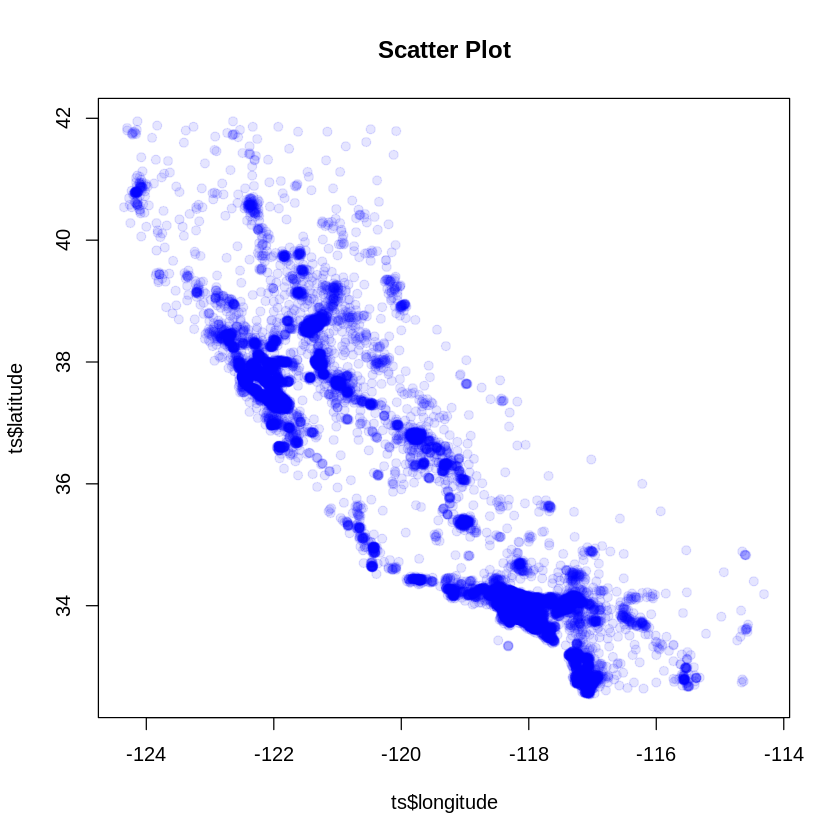

In [14]:
# draw a scatter plot of lat and lon that emphasises density using opacity
plot (ts$longitude, ts$latitude, main="Scatter Plot", col=adjustcolor("#0000FF", alpha.f = 0.1), pch=19)

It is now clear to see the high density areas, which I’m told are the Bay area, Los Angeles and San Diego plus a long line of fairly high density in the Central Valley i.e. Sacramento and Frenso.

Now, let’s add housing prices as a heat map:

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



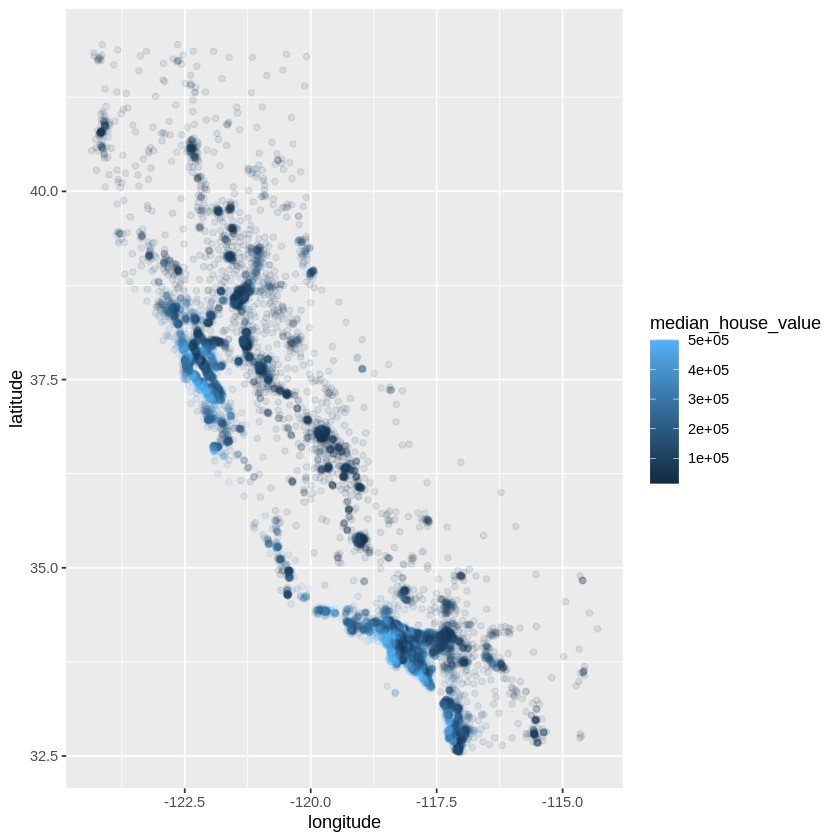

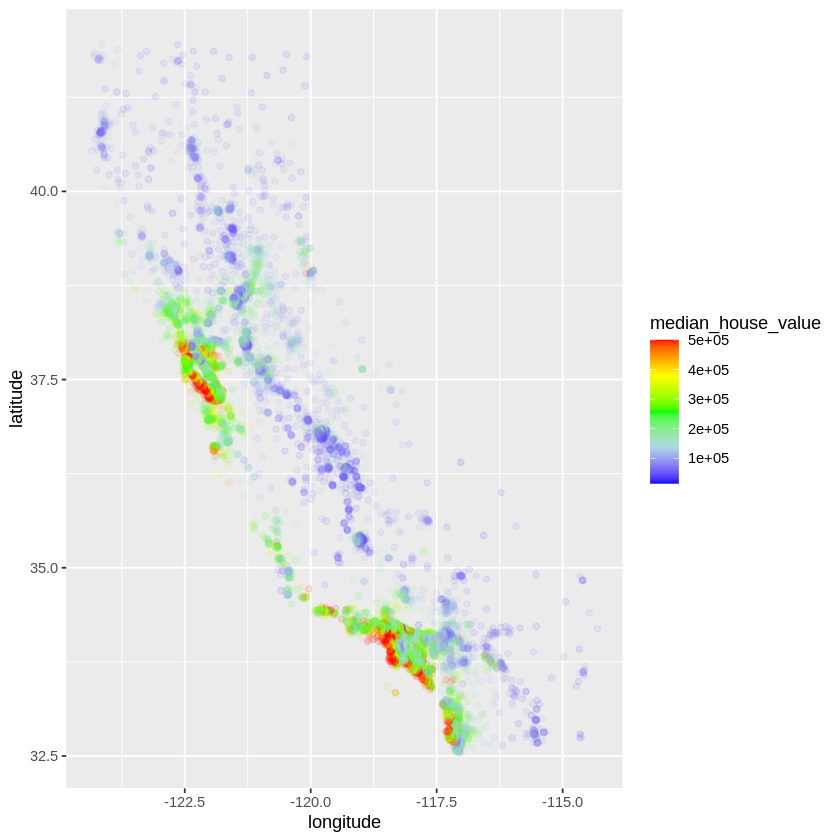

In [16]:
install.packages("farver")
library(ggplot2)
library(farver)

testd = data.frame(longitude = ts$longitude, latitude = ts$latitude, median_house_value = ts$median_house_value)
ggplot(data = testd, mapping = aes(x = longitude, y = latitude)) + geom_point(aes(color = median_house_value), shape = 19, alpha = 0.1)
last_plot() + scale_color_gradientn(colors=c("red", "yellow", "green", "lightblue", "blue"), values=c(1, 0.75, 0.5, 0.25, 0))

This clearly shows us that the housing prices are very much related to the location (i.e. close to the ocean) and to the population density. I think a further thing to do would be to use a clustering algorithm, which is outside the scope of this course.



**Looking for Correlations**

Since the dataset is quite small we can easily compute the standard correlation coefficient (i.e. pearson’s r) between every pair of attributes.



In [17]:
install.packages("Hmisc")
library(Hmisc)



Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘png’, ‘jpeg’, ‘checkmate’, ‘Formula’, ‘latticeExtra’, ‘acepack’, ‘gridExtra’, ‘data.table’, ‘htmlTable’, ‘viridis’


Loading required package: lattice

Loading required package: survival

Loading required package: Formula


Attaching package: ‘Hmisc’


The following objects are masked from ‘package:base’:

    format.pval, units




In [25]:

newts1 <- data.frame(ts$median_house_value, ts$median_income, ts$total_rooms, ts$housing_median_age, ts$households, ts$total_bedrooms, ts$population, ts$longitude, ts$latitude)
cor(newts1, newts1, use="complete.obs", method="pearson")


ts.median_house_value ts.median_income ts.total_rooms
ts.median_house_value  1.00000000            0.6918706038     0.13099147   
ts.median_income       0.69187060            1.0000000000     0.19538281   
ts.total_rooms         0.13099147            0.1953828074     1.00000000   
ts.housing_median_age  0.10675771           -0.1159316246    -0.36098417   
ts.households          0.06103063            0.0076437162     0.91901830   
ts.total_bedrooms      0.04578305           -0.0134946823     0.92840299   
ts.population         -0.02785006           -0.0006376291     0.86017034   
ts.longitude          -0.04498170           -0.0154849614     0.04701044   
ts.latitude           -0.14491672           -0.0803030138    -0.03877257   
                      ts.housing_median_age ts.households ts.total_bedrooms
ts.median_house_value  0.1067577             0.061030634   0.04578305      
ts.median_income      -0.1159316             0.007643716  -0.01349468      
ts.total_rooms        -0.3609842             0.919018298   0.92840299      
ts.housing_median_age  1.0000000            -0.302754191  -0.32043408      
ts.households         -0.3027542             1.000000000   0.98092009      
ts.total_bedrooms     -0.3204341             0.980920092   1.00000000      
ts.population         -0.2958898             0.909246530   0.88116857      
ts.longitude          -0.1142503             0.059627704   0.07180196      
ts.latitude            0.0164539            -0.074902297  -0.06937292      
                      ts.population ts.longitude ts.latitude
ts.median_house_value -0.0278500611 -0.04498170  -0.14491672
ts.median_income      -0.0006376291 -0.01548496  -0.08030301
ts.total_rooms         0.8601703408  0.04701044  -0.03877257
ts.housing_median_age -0.2958898054 -0.11425031   0.01645390
ts.households          0.9092465299  0.05962770  -0.07490230
ts.total_bedrooms      0.8811685744  0.07180196  -0.06937292
ts.population          1.0000000000  0.10167426  -0.11126136
ts.longitude           0.1016742646  1.00000000  -0.92520828
ts.latitude           -0.1112613615 -0.92520828   1.00000000

Which gives a correlation matrix. 

The correlation coefficient ranges from -1 to 1. When it is close to 1, it means there is a strong positive correlation; for example the median house value tends to go up when the median income goes up (i.e. 0.69187060). When it is close to -1, it means there is a strong negative relationship. There are small negative correlations between latitude and median house values i.e. prices go down as you go North. Correlations close to zero mean there is no correlation.

Here is an example:

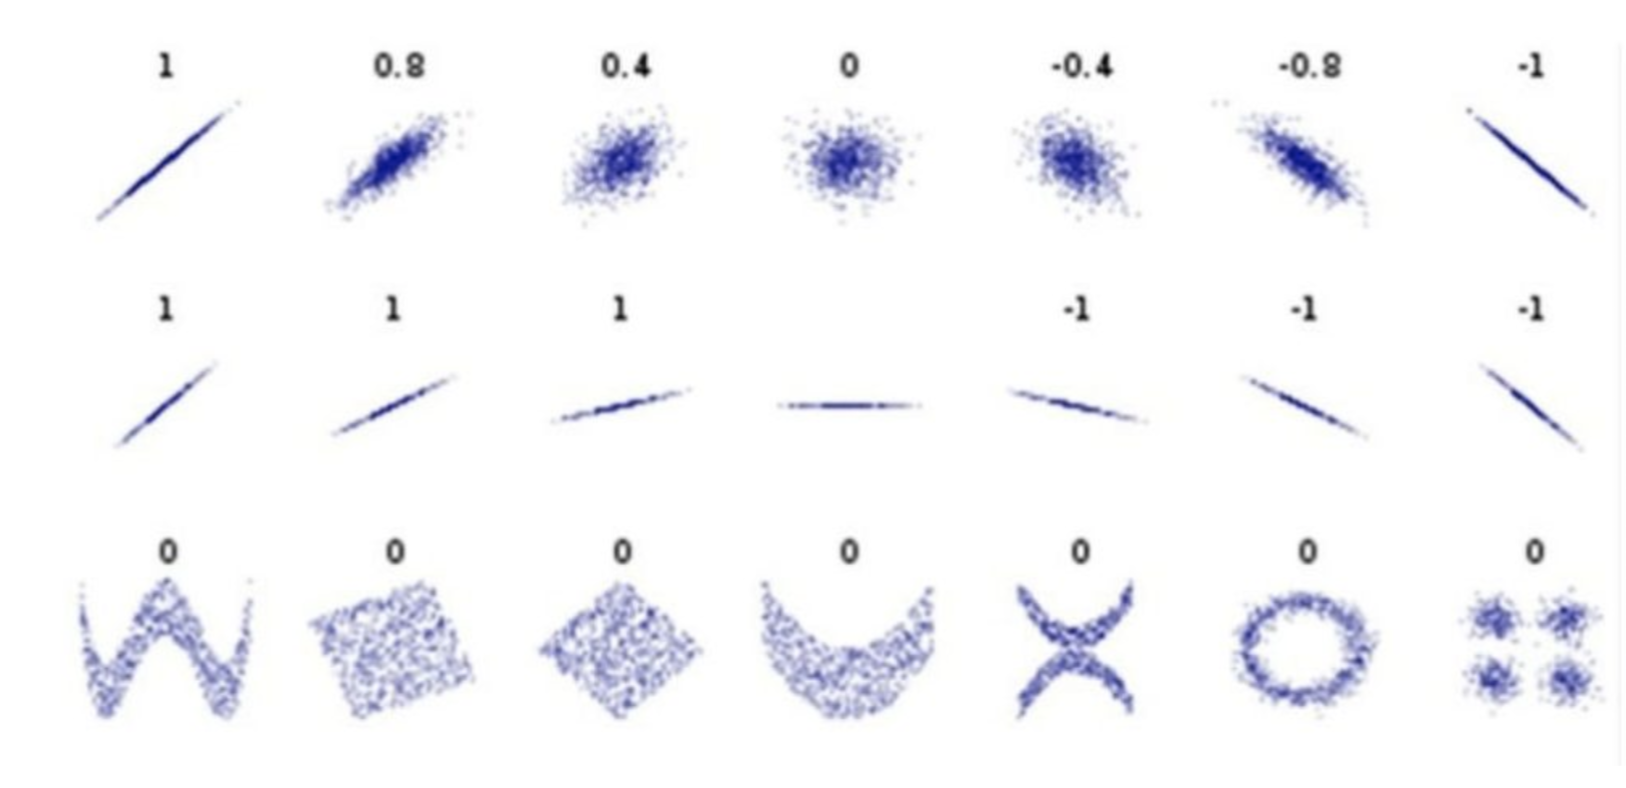

Standard correlation coefficient of different datasets (Wikipedia; public domain image)

A scatter matrix is another way to check for correlation between attributes. Let’s look at a select few that are important and correlate with median housing value:

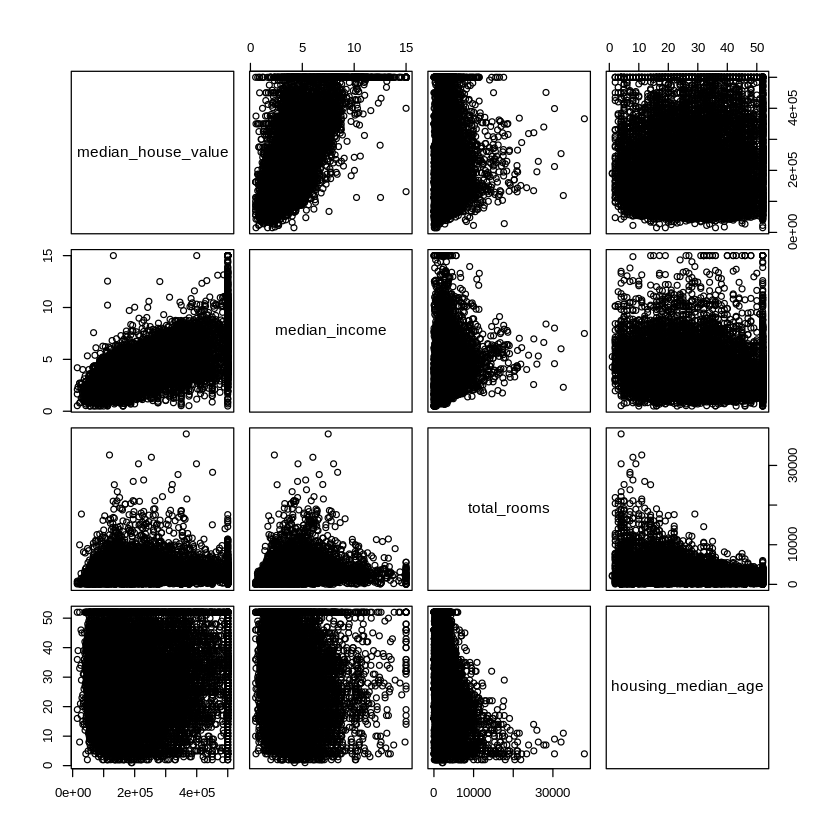

In [26]:
iristest = data.frame(median_house_value = ts$median_house_value, median_income = ts$median_income, total_rooms = ts$total_rooms, housing_median_age = ts$housing_median_age)
pairs(iristest[,1:4])

As we can see the most promising attribute to predict median house value is the comparison with median income, so let’s looks closely:

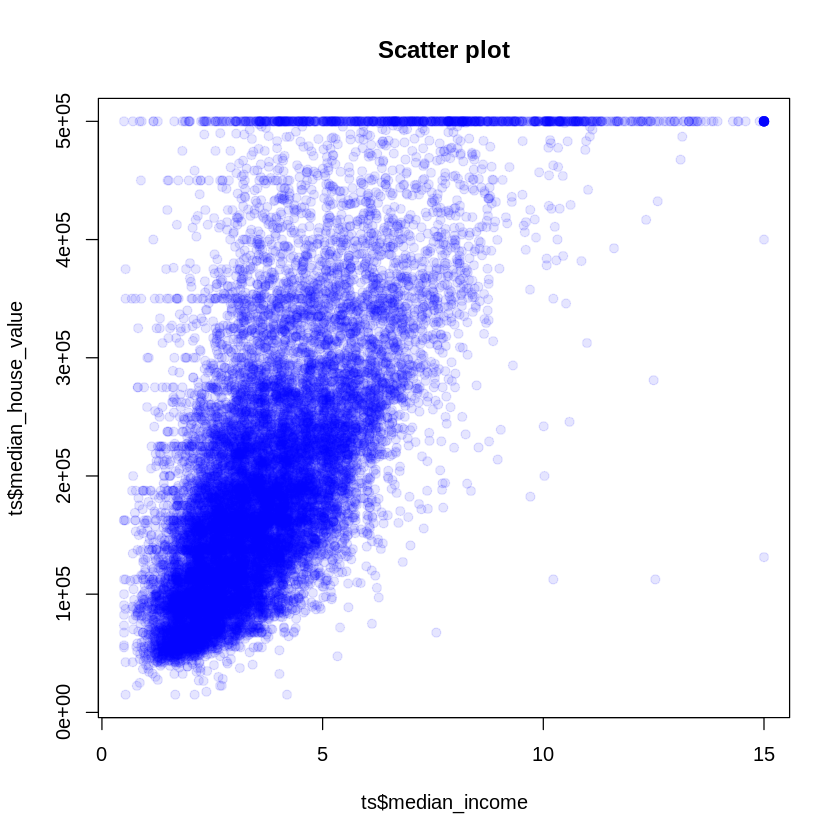

In [27]:
plot(ts$median_income, ts$median_house_value, main="Scatter plot", col=alpha(colours,0.1), pch=19)

As we can see, the correlation is strong as shown by the upward trend and the points are quite close together. As mentioned earlier, the cap at $500000 can be shown as a straight line, but there also seems to be two other quirks at around $450000, $350000 and $280000 and some others below. This is something you should try to resolve by removing these corresponding districts to avoid your algorithms learning and reproducing these quirks.

**Experimenting with Attribute Combinations**

So, we have now learned some cool ways to explore data and get insight and we have identified some quirks we want to clean up, some interesting correlations and ones in particular with the target attribute. Don’t forget the heavy-tail issue that can be resolved by computing their logarithm.

The next thing we want to do is test various attribute combinations i.e. total number of rooms in a district is not useful of you don’t know the number of households, so we want to know the number of rooms per household. Similarly, the total number of bedrooms should be compared with the total number of rooms, also, population per household. So, we create these and check the new correlation matrix:

In [28]:
ts$rooms_per_household <- ts$total_rooms/ts$households
ts$bedrooms_per_room <- ts$total_bedrooms/ts$total_rooms
ts$population_per_household <- ts$population/ts$households

newts2 <- data.frame(ts$median_house_value, ts$median_income, ts$rooms_per_household, ts$total_rooms, ts$housing_median_age, ts$households, ts$total_bedrooms, ts$population_per_household, ts$population, ts$longitude, ts$latitude, ts$bedrooms_per_room)
cor(newts2, newts2, use="complete.obs", method="pearson")

ts.median_house_value ts.median_income
ts.median_house_value        1.00000000            0.6918706038   
ts.median_income             0.69187060            1.0000000000   
ts.rooms_per_household       0.15008136            0.3173108463   
ts.total_rooms               0.13099147            0.1953828074   
ts.housing_median_age        0.10675771           -0.1159316246   
ts.households                0.06103063            0.0076437162   
ts.total_bedrooms            0.04578305           -0.0134946823   
ts.population_per_household -0.04276381           -0.0098264457   
ts.population               -0.02785006           -0.0006376291   
ts.longitude                -0.04498170           -0.0154849614   
ts.latitude                 -0.14491672           -0.0803030138   
ts.bedrooms_per_room        -0.25818951           -0.6176383205   
                            ts.rooms_per_household ts.total_rooms
ts.median_house_value        0.150081358            0.13099147   
ts.median_income             0.317310846            0.19538281   
ts.rooms_per_household       1.000000000            0.12538457   
ts.total_rooms               0.125384567            1.00000000   
ts.housing_median_age       -0.146234241           -0.36098417   
ts.households               -0.084505165            0.91901830   
ts.total_bedrooms           -0.006479621            0.92840299   
ts.population_per_household  0.001476071           -0.03532690   
ts.population               -0.074806113            0.86017034   
ts.longitude                -0.032893874            0.04701044   
ts.latitude                  0.110017015           -0.03877257   
ts.bedrooms_per_room        -0.408199972           -0.18291425   
                            ts.housing_median_age ts.households
ts.median_house_value        0.106757707           0.061030634 
ts.median_income            -0.115931625           0.007643716 
ts.rooms_per_household      -0.146234241          -0.084505165 
ts.total_rooms              -0.360984166           0.919018298 
ts.housing_median_age        1.000000000          -0.302754191 
ts.households               -0.302754191           1.000000000 
ts.total_bedrooms           -0.320434083           0.980920092 
ts.population_per_household  0.006273598          -0.040083511 
ts.population               -0.295889805           0.909246530 
ts.longitude                -0.114250306           0.059627704 
ts.latitude                  0.016453903          -0.074902297 
ts.bedrooms_per_room         0.133440760           0.074661618 
                            ts.total_bedrooms ts.population_per_household
ts.median_house_value        0.045783052      -0.042763810               
ts.median_income            -0.013494682      -0.009826446               
ts.rooms_per_household      -0.006479621       0.001476071               
ts.total_rooms               0.928402988      -0.035326896               
ts.housing_median_age       -0.320434083       0.006273598               
ts.households                0.980920092      -0.040083511               
ts.total_bedrooms            1.000000000      -0.043553265               
ts.population_per_household -0.043553265       1.000000000               
ts.population                0.881168574       0.076362230               
ts.longitude                 0.071801956       0.028951175               
ts.latitude                 -0.069372915      -0.032783639               
ts.bedrooms_per_room         0.094689624      -0.010605856               
                            ts.population ts.longitude ts.latitude
ts.median_house_value       -0.0278500611 -0.04498170  -0.14491672
ts.median_income            -0.0006376291 -0.01548496  -0.08030301
ts.rooms_per_household      -0.0748061133 -0.03289387   0.11001702
ts.total_rooms               0.8601703408  0.04701044  -0.03877257
ts.housing_median_age       -0.2958898054 -0.11425031   0.01645390
ts.households                0.9092465299  0.05962770  -0.07490230
ts.total_bedrooms            0.88116

Fantastic!! bedrooms_per_room is more correlated with median_house_value than the total number of rooms or bedrooms. It seems that houses with a lower bedroom per room ratio tend to be more expensive. Also, the number of rooms per household is more informative than the total number of rooms in a district where it is obvious that the larger the houses, the more expensive they are. This is iterative and not required to be exhaustive. So, once you have a prototype you could typically come back to this exploration step.

**4. Prepare the data for Machine Learning Algorithms**

Now, we should consider preparing the data for Machine Learning. This should normally be done by functions as you will be able to:
- Reproduce the transformations on a new dataset easily
- Build a library of transformations that can be reused in future projects
- Use the functions on your live system to transform new data
- Try out various combinations of transformations and see what works best

From the Machine learning perspective you will do most of this with Python and Tensorflow.

Most ML algorithms can’t work with missing features, so I will explain how to clean the data.
We were lucky that there is no missing data, but if there is we need to fix this and we have 3 options:
1. Get rid of the corresponding districts (i.e. the rows of data where NA’s appear)
2. Get rid of the whole attribute (i.e. drop total_bedrooms completely)
3. Set the NA values to some value (i.e. zero, the mean, the median etc.

Here is the code for this:

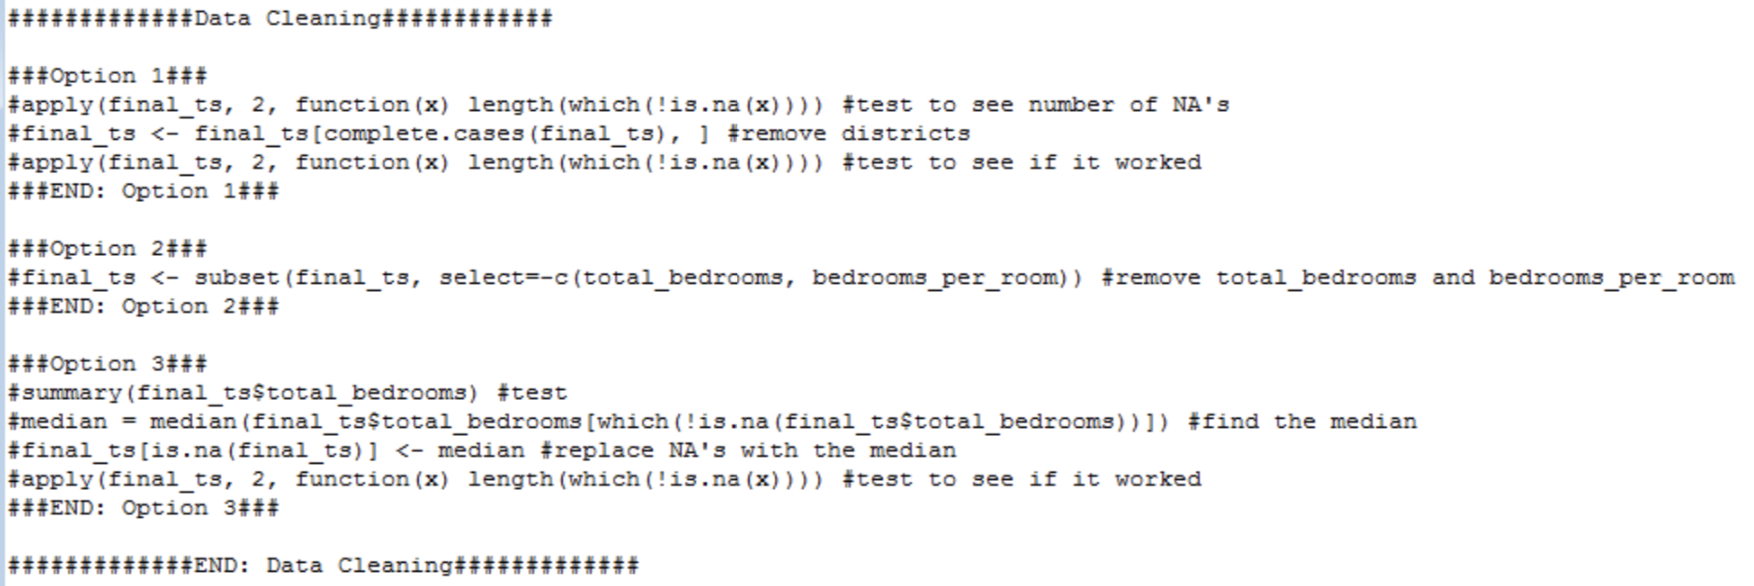

Remember to keep the value of the median for using on your training set at a later point. We won’t be doing that here as we will use other data for our Deep Learning Neural Network.

We also need to handle text and categorical attributes. We unfortunately don't have this in our data, but again, here is an example of converting categories to numbers:

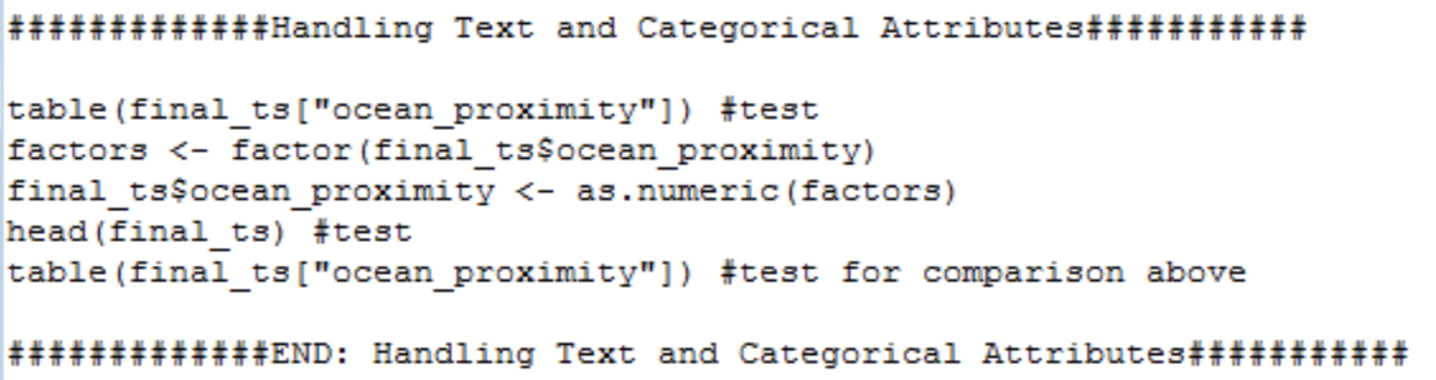

And this gives the following output:

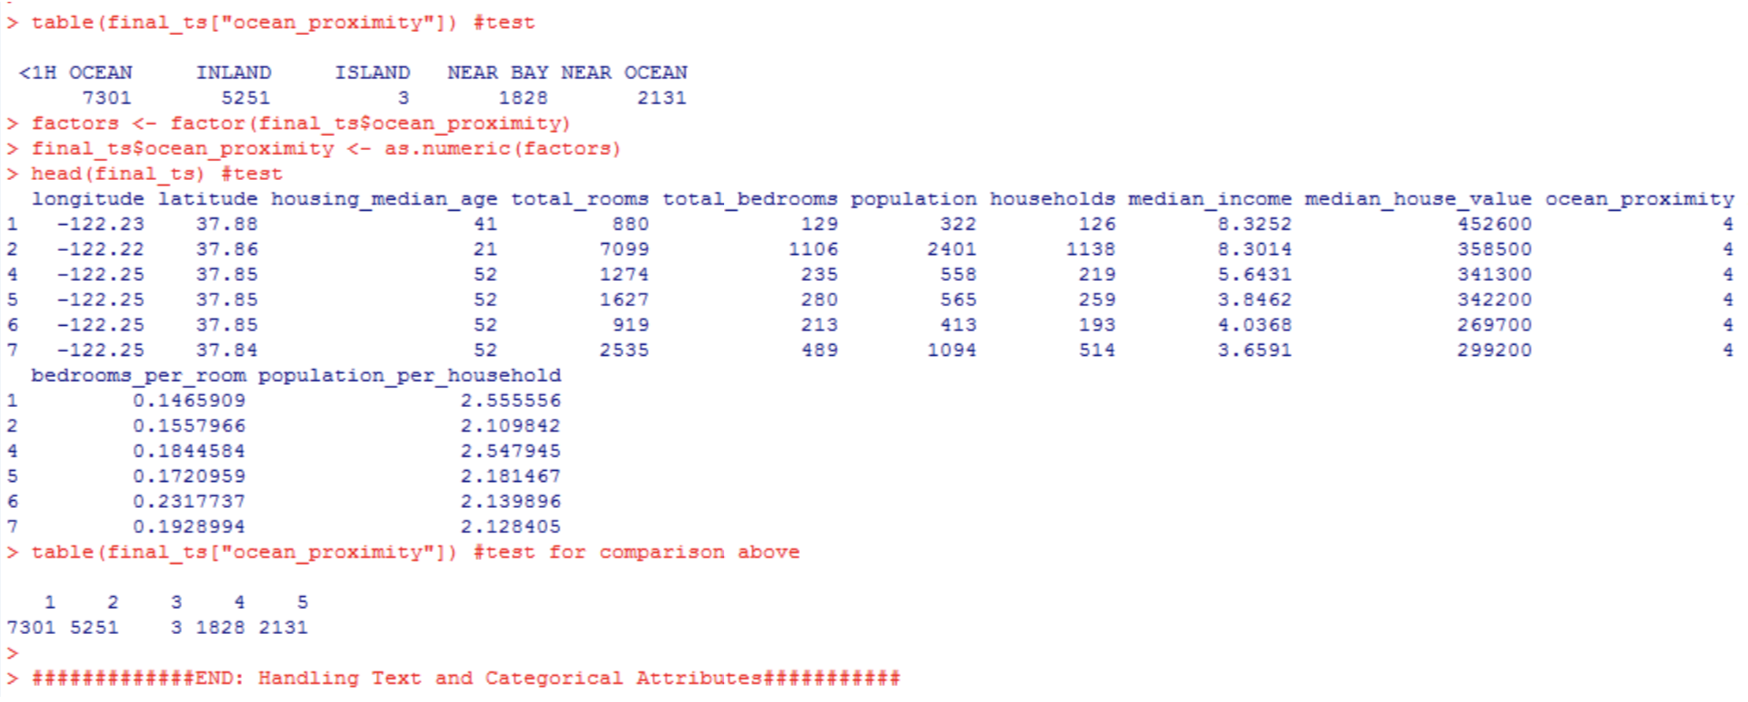

As you can see, ocean proximity now has numerical values. OCEAN = 1, INLAND = 2, ISLAND = 3, NEAR BAY = 4 and NEAR OCEAN = 5.

Next, we want to carry out some feature scaling. This is a very important transformation as ML algorithms don’t tend to perform well when the input numerical attributes have very different scales. So, for housing data, the total number of rooms ranges from about 6 to 39320. Scaling your targets is not generally required.
We will normalise total rooms:

In [29]:
final_ts <- ts
final_ts$total_rooms <- scale(final_ts$total_rooms)
summary(final_ts)

   longitude         latitude     housing_median_age   total_rooms.V1   
 Min.   :-124.3   Min.   :32.54   Min.   : 1.00      Min.   :-1.211802  
 1st Qu.:-121.8   1st Qu.:33.93   1st Qu.:18.00      1st Qu.:-0.542061  
 Median :-118.5   Median :34.25   Median :29.00      Median :-0.237008  
 Mean   :-119.6   Mean   :35.63   Mean   :28.59      Mean   : 0.000000  
 3rd Qu.:-118.0   3rd Qu.:37.72   3rd Qu.:37.00      3rd Qu.: 0.232843  
 Max.   :-114.3   Max.   :41.95   Max.   :52.00      Max.   :16.189997  
 total_bedrooms     population      households     median_income    
 Min.   :   1.0   Min.   :    3   Min.   :   1.0   Min.   : 0.4999  
 1st Qu.: 297.0   1st Qu.:  790   1st Qu.: 282.0   1st Qu.: 2.5664  
 Median : 434.0   Median : 1167   Median : 409.0   Median : 3.5446  
 Mean   : 539.4   Mean   : 1430   Mean   : 501.2   Mean   : 3.8836  
 3rd Qu.: 648.2   3rd Qu.: 1721   3rd Qu.: 605.2   3rd Qu.: 4.7670  
 Max.   :6445.0   Max.   :35682   Max.   :6082.0   Max.   :15.0001  
 media

As you can see total_rooms is now normalised with a mean of 0.

**5. Select and Train a model**

At this stage you have framed the problem, got the data and explored it, sampled the training set and the test set and did some transformations.

However, in this instance, we want to export the data to a csv for training and test sets as we will use TensorFlow for machine learning. We won’t use this data, but please feel free to attempt this yourself.

We can export the data like so:

In [31]:
write.csv(final_ts, file="/content/finalts.csv")

Now, you can explore the file system on the left of this window and find your data there. You can even download it to here if you prefer.

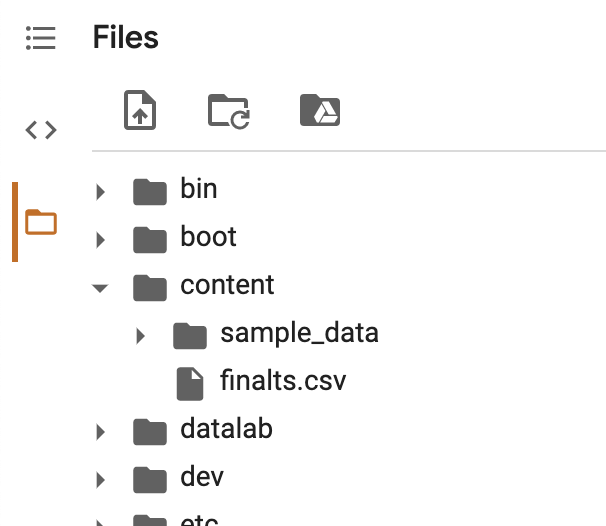



**Go back to the course document**